In [22]:
#perform neighbor enrichment analysis with squidpy
import anndata
import pandas as pd
import cellcharter as cc
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import time, os, sys
import glob
import warnings
import numpy as np
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
#import simualted data

# Load in dataset. This is a .csv file with all samples concatenated together
# as clustering needs to be performed on all samples at once
# sample_id indicates where sample comes fromn for spatial_lda function
#path_to_csv = './../../../SCNA_thesis/data/Sim_nbh15_asym01_1000_grid0.2_1kiter_025kswap'
#path_to_csv = './../../../SCNA_thesis/data/Sim_nbh15_asym01_1000_grid0.2_1kiter_025kswap_abundance_range_005_055/'
# path_to_csv = './../../../SCNA_thesis/github/IST_gen/IST_generation_SCNA/sanity_check_3/'
#path_to_csv = './../../../SCNA_thesis/data/Sim_nbh2_sym00_1000_grid0.2_300iter_50swap'
path_to_csv = './../../../SCNA_thesis/data/20250217_sym00_nbh2_1000dim_grid200_300iter_50swaps/'
#path_to_csv = './../../../MI_heart_paper/data/cell_table_final.csv'


# read in all csv files (they all have ct, x and y coordinates) give them a new sample id column of their file names and row bind them all to one big dataframe
# Use glob to get all the CSV files in the folder
csv_files = glob.glob(os.path.join(path_to_csv, '*.csv'))

# Initialize an empty list to store individual DataFrames
data_frames = []

# Loop through the CSV files and process each one
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)

    # Extract the file name without the extension and path
    sample_id = os.path.splitext(os.path.basename(file))[0]

    # Add a new column for the sample ID
    df['sample_id'] = sample_id

    # Append the DataFrame to the list
    data_frames.append(df)

# Concatenate all DataFrames into one big DataFrame
obs = pd.concat(data_frames, ignore_index=True)


In [3]:
obs

,x,y,ct,sample_id
0,0.000000,0.000000,3.0,cross01_0.45_ab0_0.15_44
1,26.092384,0.000000,0.0,cross01_0.45_ab0_0.15_44
2,50.183110,0.000000,3.0,cross01_0.45_ab0_0.15_44
3,77.284590,0.000000,3.0,cross01_0.45_ab0_0.15_44
4,101.850801,0.000000,2.0,cross01_0.45_ab0_0.15_44
...,...,...,...,...
4283227,961.254256,784.658135,0.0,cross01_0.45_ab0_0.1_17
4283228,348.721290,306.527478,2.0,cross01_0.45_ab0_0.1_17
4283229,392.800743,313.550889,1.0,cross01_0.45_ab0_0.1_17
4283230,474.066686,92.531446,1.0,cross01_0.45_ab0_0.1_17


In [44]:
# add marker files to it, as SpatialLDA needs them
obs['D'] = np.random.randint(1, 101, size=len(obs))
obs['E'] = np.random.randint(1, 101, size=len(obs))

# Load dataframe into anndata object
# dataframe for annotating the observations
obs = obs.astype({'ct':'string'})

# the data matrix 
X = obs[['D', 'E']]
X = X.values
adata = anndata.AnnData(X)
adata.obs = obs

adata.obs

,x,y,ct,sample_id,D,E
0,0.000000,0.000000,1.0,self00_0.6_ab0_0.15_13,95,20
1,24.534492,0.000000,0.0,self00_0.6_ab0_0.15_13,77,79
2,52.289758,0.000000,0.0,self00_0.6_ab0_0.15_13,22,11
3,79.509940,0.000000,2.0,self00_0.6_ab0_0.15_13,55,62
4,102.494435,0.000000,2.0,self00_0.6_ab0_0.15_13,23,6
...,...,...,...,...,...,...
4283227,1000.000000,507.264433,2.0,self00_0.6_ab0_0.05_7,82,10
4283228,187.994456,853.032888,1.0,self00_0.6_ab0_0.05_7,2,91
4283229,155.090592,758.147251,0.0,self00_0.6_ab0_0.05_7,47,88
4283230,977.121401,36.181175,1.0,self00_0.6_ab0_0.05_7,49,15


In [45]:
# get spatial coordinates to be in obsm
adata.obsm['spatial'] = obs[['x', 'y']].values
# make "refined_cell_types" a categorical variable
adata.obs['ct'] = pd.Categorical(adata.obs['ct'])

In [46]:

# Assuming 'FOV' is the column in obs indicating different fields of view
fov_list = adata.obs['sample_id'].unique()

# Dictionary to store FOV-specific AnnData objects
fov_adata_dict = {}

# Loop over each FOV
for fov in fov_list:
    # Create a subset of adata for the specific FOV
    fov_adata = adata[adata.obs['sample_id'] == fov].copy()

    # Perform spatial neighbors analysis on the subset
    sq.gr.spatial_neighbors(fov_adata, coord_type = 'generic', delaunay=True)
    cc.gr.nhood_enrichment(fov_adata, cluster_key="ct", only_inter=True, n_perms=300, pvalues=False, batch_size=10, symmetric = False)
    # Store the result in the dictionary
    fov_adata_dict[fov] = fov_adata


/Users/chiaraschiller/miniconda3/envs/cellcharter/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/chiaraschiller/miniconda3/envs/cellcharter/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/chiaraschiller/miniconda3/envs/cellcharter/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/chiaraschiller/miniconda3/envs/cellcharter/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/chiaraschiller/miniconda3/env

In [47]:
fov_adata.uns['ct_nhood_enrichment']['enrichment']

,0.0,1.0,2.0,3.0
0.0,NaN,0.059999,0.040705,0.042233
1.0,0.049353,NaN,0.131862,0.114790
2.0,0.039424,0.133945,NaN,0.119260
3.0,0.036761,0.114389,0.117280,NaN


In [48]:
import pandas as pd

# Initialize a list to hold each flattened DataFrame
flattened_dfs = []

# Loop through each fov in the dictionary
for fov, fov_adata in fov_adata_dict.items():
    # Extract the zscore matrix
    zscore_matrix = fov_adata.uns['ct_nhood_enrichment']['enrichment']

    # Get the refined cell types from adata.obs (ensure it's categorical)
    cell_types = fov_adata.obs['ct'].cat.categories

    # Check if the dimensions of the zscore matrix match the number of categories
    assert len(cell_types) == zscore_matrix.shape[0] == zscore_matrix.shape[1], "Dimension mismatch!"

    # Convert the zscore matrix to a pandas DataFrame with correct row and column names
    zscore_df = pd.DataFrame(zscore_matrix, index=cell_types, columns=cell_types)

    # Flatten the DataFrame
    flattened_df = zscore_df.stack().reset_index()

    # Rename the columns to combine row and column names
    flattened_df.columns = ['rowname', 'colname', 'count']

    # Create a new column for combined names
    flattened_df['combined'] = flattened_df['rowname'] + '_' + flattened_df['colname']

    # Add a column for the FOV name
    flattened_df['sample_id'] = fov

    # Retain only the combined, zscore, and fov columns
    flattened_df = flattened_df[['sample_id', 'combined', 'count']]

    # Append the flattened DataFrame to the list
    flattened_dfs.append(flattened_df)

# Concatenate all flattened DataFrames into one big DataFrame
big_dataframe = pd.concat(flattened_dfs, ignore_index=True)

# Pivot the DataFrame to have FOVs as row names and combined names as column names
final_dataframe = big_dataframe.pivot(index='sample_id', columns='combined', values='count')

# Reset the index to make FOV a column (optional)
final_dataframe.reset_index('sample_id',inplace=True)

# Display the final DataFrame
print(final_dataframe)


combined               sample_id   0.0_1.0   0.0_2.0   0.0_3.0   1.0_0.0  \
0                 ran_ab0_0.05_1  0.070040  0.080817  0.073348  0.077617   
1                ran_ab0_0.05_10  0.094246  0.050709  0.078700  0.096527   
2               ran_ab0_0.05_100  0.082858  0.074051  0.053617  0.084839   
3                ran_ab0_0.05_11  0.065090  0.075780  0.074099  0.076555   
4                ran_ab0_0.05_12  0.080135  0.074001  0.078410  0.089794   
...                          ...       ...       ...       ...       ...   
2395      self00_0.6_ab0_0.55_95  0.106481  0.129162  0.148887  0.015703   
2396      self00_0.6_ab0_0.55_96  0.130832  0.116146  0.126191  0.059564   
2397      self00_0.6_ab0_0.55_97  0.143942  0.135953  0.128634  0.056159   
2398      self00_0.6_ab0_0.55_98  0.127010  0.130180  0.145581  0.034806   
2399      self00_0.6_ab0_0.55_99  0.153501  0.124348  0.123712  0.032433   

combined   1.0_2.0   1.0_3.0   2.0_0.0   2.0_1.0   2.0_3.0   3.0_0.0  \
0         0.093

In [49]:
final_dataframe.to_csv('./../../../SCNA_thesis/github/Comparison/20250218_results_sym/cellcharter_asymmetric_nohomo_enrichment_delaunay_4ct_self00.csv', index=False)  # Set index=False to avoid saving the index as a column
final_dataframe

combined,sample_id,0.0_1.0,0.0_2.0,0.0_3.0,1.0_0.0,1.0_2.0,1.0_3.0,2.0_0.0,2.0_1.0,2.0_3.0,3.0_0.0,3.0_1.0,3.0_2.0
0,ran_ab0_0.05_1,0.070040,0.080817,0.073348,0.077617,0.093908,0.094510,0.076554,0.082320,0.085967,0.078246,0.091809,0.094865
1,ran_ab0_0.05_10,0.094246,0.050709,0.078700,0.096527,0.057673,0.091876,0.070523,0.073638,0.114808,0.082698,0.091806,0.096796
2,ran_ab0_0.05_100,0.082858,0.074051,0.053617,0.084839,0.101241,0.079318,0.069261,0.091091,0.102806,0.062018,0.082210,0.116691
3,ran_ab0_0.05_11,0.065090,0.075780,0.074099,0.076555,0.094958,0.096918,0.077906,0.085870,0.094525,0.076288,0.087660,0.094352
4,ran_ab0_0.05_12,0.080135,0.074001,0.078410,0.089794,0.099375,0.073782,0.074279,0.088547,0.095620,0.080918,0.065929,0.099211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,self00_0.6_ab0_0.55_95,0.106481,0.129162,0.148887,0.015703,0.095035,0.097943,0.042073,0.092098,0.062824,0.058594,0.090696,0.060504
2396,self00_0.6_ab0_0.55_96,0.130832,0.116146,0.126191,0.059564,0.090321,0.062630,0.040585,0.089933,0.081432,0.056959,0.062743,0.082665
2397,self00_0.6_ab0_0.55_97,0.143942,0.135953,0.128634,0.056159,0.075240,0.079600,0.051888,0.075892,0.065823,0.042247,0.079804,0.064817
2398,self00_0.6_ab0_0.55_98,0.127010,0.130180,0.145581,0.034806,0.073156,0.085943,0.047664,0.078709,0.069749,0.056342,0.085884,0.064976


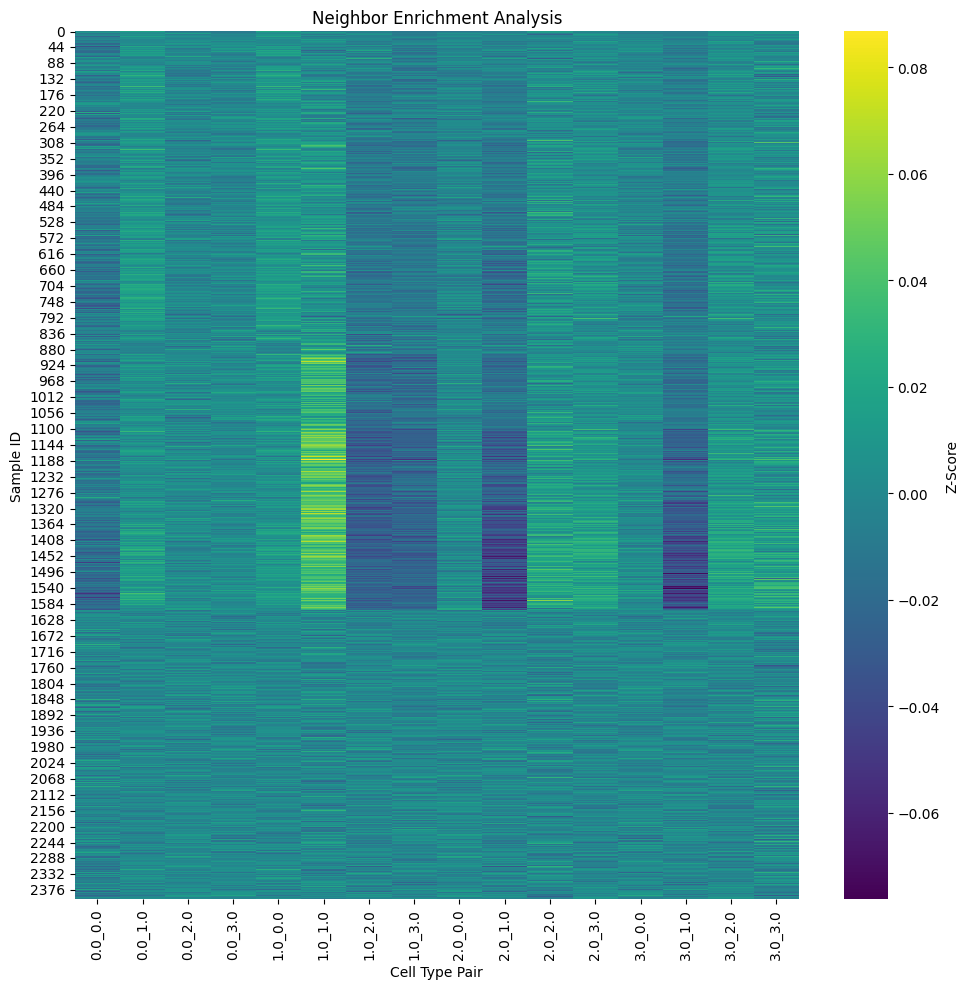

In [28]:
# make a heatmap of final_dataframe
# Plot the heatmap
# make first columns to index and delete first column
#final_dataframe.set_index('sample_id', inplace=True)
final_dataframe = final_dataframe.iloc[:, 1:]
plt.figure(figsize=(10, 10))
sns.heatmap(final_dataframe, cmap="viridis", cbar_kws={'label': 'Z-Score'})
plt.title("Neighbor Enrichment Analysis")
plt.xlabel("Cell Type Pair")
plt.ylabel("Sample ID")
plt.tight_layout()
plt.show()